Machine learning model using time series dataset<br>
Ellion Blessan<br>
ellionblessan@gmail.com

Dataset: [Air Quality Data in India (2017 - 2022) | Kaggle](https://www.kaggle.com/datasets/fedesoriano/air-quality-data-in-india)

# Importing dependencies

In [3]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
air_data = pd.read_csv('air-quality-india.csv')
air_data

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50
...,...,...,...,...,...,...
36187,2022-06-04 11:00:00,2022,6,4,11,35.89
36188,2022-06-04 12:00:00,2022,6,4,12,33.83
36189,2022-06-04 13:00:00,2022,6,4,13,33.05
36190,2022-06-04 14:00:00,2022,6,4,14,35.29


# Pre-processing dataset

In [21]:
hour_pm = air_data.drop(['Year', 'Month', 'Day', 'Hour'], axis=1)
hour_pm.set_index('Timestamp', inplace= True)
hour_pm

,PM2.5
Timestamp,
2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,116.50
...,...
2022-06-04 11:00:00,35.89
2022-06-04 12:00:00,33.83
2022-06-04 13:00:00,33.05


In [7]:
hour_pm.isnull().sum()

PM2.5    0
dtype: int64

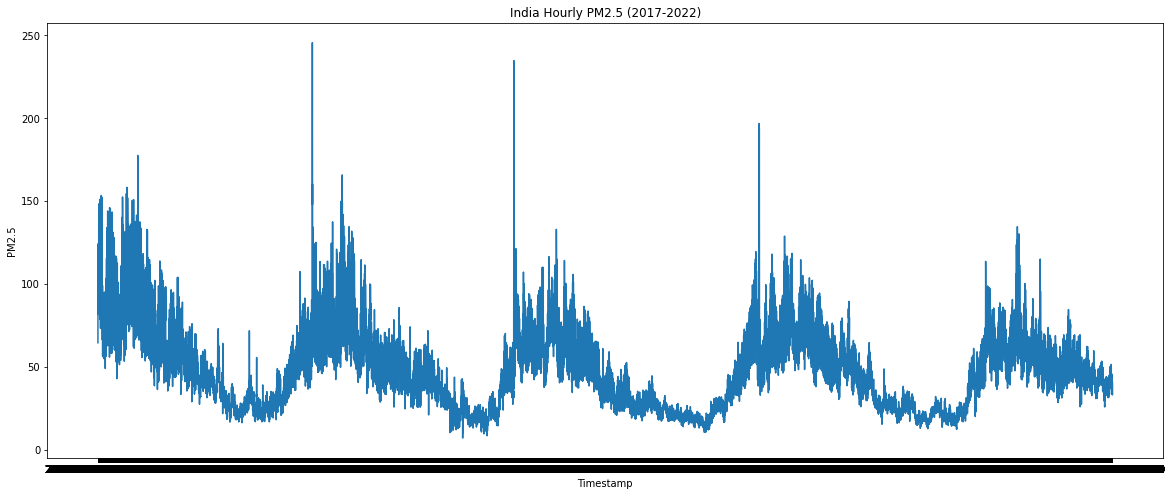

In [8]:
plt.figure(figsize=(20,8))
plt.plot(hour_pm)
plt.title('India Hourly PM2.5 (2017-2022)')
plt.xlabel('Timestamp')
plt.ylabel('PM2.5')
plt.show()

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_pm = scaler.fit_transform(hour_pm.values)
scaled_pm

array([[0.24093709],
       [0.2637358 ],
       [0.35945685],
       ...,
       [0.10909015],
       [0.11847785],
       [0.1410251 ]])

In [10]:
timestamp = air_data['Timestamp'].values
pm = air_data['PM2.5'].values

# Model and plot

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [13]:
threshold = (scaled_pm.max() - scaled_pm.min()) * 10/100
threshold

0.1

In [14]:
x_train, x_test, y_train, y_test = train_test_split(scaled_pm, timestamp, test_size=0.2, 
                                                    random_state=0 , shuffle=False)

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold):
      self.model.stop_training = True
      print("\nMean Absolute Error of the model has reached less than 10% of data scale")
callbacks = myCallback()

In [16]:
train_pm = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
test_pm = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(None, 1)),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dense(25, activation="relu"),
  tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [18]:
history = model.fit(train_pm, epochs=100, validation_data=test_pm, callbacks=[callbacks])

Epoch 1/100
289/289 [==============================] - 37s 114ms/step - loss: 0.0120 - mae: 0.1164 - val_loss: 0.0041 - val_mae: 0.0731
Epoch 2/100
289/289 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0882
Mean Absolute Error of the model has reached less than 10% of data scale
289/289 [==============================] - 32s 107ms/step - loss: 0.0065 - mae: 0.0882 - val_loss: 0.0034 - val_mae: 0.0675


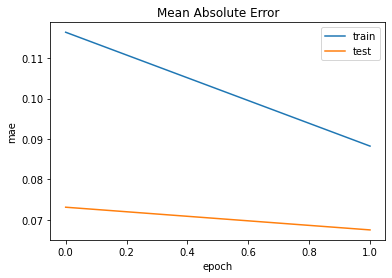

In [19]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

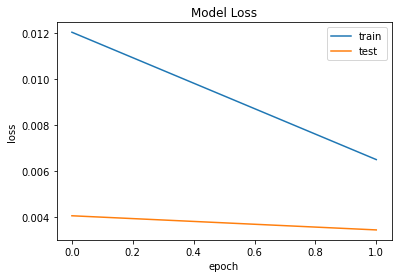

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()